In [2]:
import sys
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix


project_root = Path("..").resolve()
sys.path.append(str(project_root))

In [3]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

clean_transform = transforms.ToTensor()

clean_dataset = datasets.MNIST(
    root="../data/raw",
    train=False,
    download=False,
    transform=clean_transform
)

clean_loader = DataLoader(
    clean_dataset,
    batch_size=512,
    shuffle=False
)

x_clean, y_clean = next(iter(clean_loader))
x_clean = x_clean.numpy()

print("Clean samples shape:", x_clean.shape)

Clean samples shape: (512, 1, 28, 28)


In [4]:
x_adv = np.load("../data/processed/x_adv_fgsm.npy")
y_adv = np.load("../data/processed/y_adv_fgsm.npy")

print("Adversarial samples shape:", x_adv.shape)

Adversarial samples shape: (128, 1, 28, 28)


In [5]:
n = min(len(x_clean), len(x_adv))

x_clean = x_clean[:n]
x_adv = x_adv[:n]

print("Using samples per class:", n)

Using samples per class: 128


In [6]:
from defenses.anomaly_detector import AnomalyDetector

detector = AnomalyDetector()
detector.fit(x_clean, x_adv)

print("Anomaly detector trained.")

Anomaly detector trained.


In [7]:
x_test = np.concatenate([x_clean, x_adv], axis=0)
y_test = np.concatenate([
    np.zeros(len(x_clean)),
    np.ones(len(x_adv))
])

y_pred = detector.predict(x_test)

print(classification_report(y_test, y_pred, target_names=["Clean", "Adversarial"]))

              precision    recall  f1-score   support

       Clean       1.00      1.00      1.00       128
 Adversarial       1.00      1.00      1.00       128

    accuracy                           1.00       256
   macro avg       1.00      1.00      1.00       256
weighted avg       1.00      1.00      1.00       256



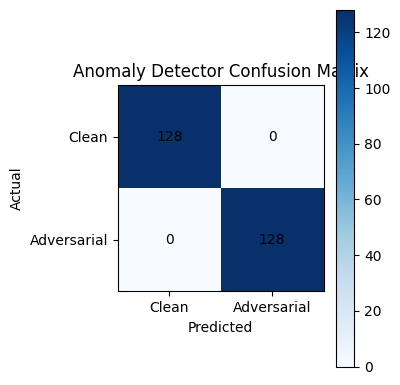

In [8]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(4, 4))
plt.imshow(cm, cmap="Blues")
plt.title("Anomaly Detector Confusion Matrix")
plt.colorbar()

plt.xticks([0, 1], ["Clean", "Adversarial"])
plt.yticks([0, 1], ["Clean", "Adversarial"])

for i in range(2):
    for j in range(2):
        plt.text(j, i, cm[i, j], ha="center", va="center")

plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

In [9]:
detector.save("../defenses/anomaly_detector.joblib")
print("Anomaly detector saved.")

Anomaly detector saved.


In [12]:
import torch
from models.mnist_cnn import MNISTCNN
from defenses.robustness_wrapper import RobustnessWrapper

model = MNISTCNN()
model.load_state_dict(torch.load("../models/mnist_cnn.pt", map_location="cpu"))

wrapper = RobustnessWrapper(
    model=model,
    detector_path="../defenses/anomaly_detector.joblib",
    device=torch.device("cpu")
)

preds, flags = wrapper.predict(x_clean[:5])
print("Predictions:", preds)
print("Flags:", flags)

Predictions: [7 2 1 0 4]
Flags: [0. 0. 0. 0. 0.]
